https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [7]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt

In [8]:
# L3/L5 cavity 生成
def unit_1(a, ny, nx, x_offset, y_offset, cavity, barrier, wgi, hole_shift):
	y_shift = a*np.sqrt(3)/2 # 0.3464
	x_shift = a
	wgi_shift = (wgi-1)*a*np.sqrt(3)
	output = list()
	y_center = y_offset - ny * y_shift
	x_center = x_offset - nx * x_shift / 2

	for j in range(ny+1):
		for i in range(nx+1):
			if 2*j == ny and abs(2*i - nx ) <= cavity - 1: #中央のcavityを作製
				continue
			elif 2*j == ny - (barrier + 1) and 2*i <= nx - cavity - barrier - 6: #結合導波路 左（バリア領域の長さが奇数のとき）
				continue
			elif 2*j == ny + (barrier + 1) and 2*i >= nx + cavity + barrier + 6: #結合導波路 右（バリア領域の長さが奇数のとき）
				continue
			else:
				if 2*j == ny and abs(2*i - nx ) == cavity + 1: #両脇のcavityの穴シフト
					x = x_center + x_shift*i + hole_shift*a*(2*i - nx)/abs(2*i - nx)
				else:
					x = x_center + x_shift*i
				if 2*j < ny - (barrier + 1) and 2*i <= nx - cavity - barrier - 6 + 1: #結合導波路 左 を (wgi-1)だけ下にシフト
					y = y_center + 2*y_shift *j - wgi_shift
				elif 2*j > ny + (barrier + 1) and 2*i >= nx + cavity + barrier + 6 - 1:#結合導波路 右 を (wgi-1)だけ上にシフト
					y = y_center + 2*y_shift *j + wgi_shift
				else:
					y = y_center + 2*y_shift *j
				output.append([x,y])

	for j in range(ny):
		for i in range(nx):
			if 2*j == ny - (barrier + 2) and 2*i <= nx - cavity - barrier - 6: #結合導波路 左（バリア領域の長さが偶数のとき）
				continue
			elif 2*j == ny + barrier and 2*i >= nx + cavity + barrier + 4: #結合導波路 右（バリア領域の長さが偶数のとき）
				continue
			else:
				x = x_center + x_shift/2 + x_shift*i
				if 2*j < ny - (barrier + 2) and 2*i <= nx - cavity - barrier - 6 + 1: #結合導波路 左 を (wgi-1)だけ下にシフト
					y = y_center + y_shift + 2*y_shift *j - wgi_shift
				elif 2*j > ny + barrier and 2*i >= nx + cavity + barrier + 4 - 1:
					y = y_center + y_shift + 2*y_shift *j + wgi_shift
				else:
					y = y_center + y_shift + 2*y_shift *j
				output.append([x,y])
	out = np.array(output)
	return out

## Transmittance

In [32]:
def phc_trans(PhC = True):
    # size of PhC (width は √3倍される)
    lengthPhC = 40
    widthPhC = 14
    
    ConnectionWaveguide = 5
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC

    a=1
    nx=widthPhC
    ny=int(lengthPhC)
    x_offset = 0
    y_offset = 0
    cavity = 5
    barrier = 3
    wgi = 1.1
    hole_shift = 0.2

    r = 1/4
    eps = 2.7**2

    # parameter
    waveguide_pos = -a*(barrier + 1 + (wgi-1)*2 )*np.sqrt(3)/2
    
    
    # geometry
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    if PhC == False:
        waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(0, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide]

    if PhC == True:
        waveguide_in = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(-(lengthPhC + ConnectionWaveguide)/2, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide_in]
        
        waveguide_out = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3( (lengthPhC + ConnectionWaveguide)/2, -waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry.append(waveguide_out)

        # Si substrate
        blk = mp.Block(mp.Vector3(lengthPhC, widthPhC*np.sqrt(3), mp.inf),
                             center=mp.Vector3(),
                             material=mp.Medium(epsilon=eps))

        geometry.append(blk)

        # airhole
        location_airhole = unit_1(a, nx, ny, x_offset, y_offset, cavity, barrier, wgi, hole_shift)
        for i in range(len(location_airhole)):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(location_airhole[i][0], location_airhole[i][1])))

    fcen = 0.29   # pulse center frequency
    df = 0.05       # pulse frequency width

    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Hz,
                         center=mp.Vector3(-length/2 +1,waveguide_pos),
                         size=mp.Vector3(0,wgi*np.sqrt(3)))
              ]


    pml_layers = [mp.PML(1.0)]
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    
    resolution = 16
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2, waveguide_pos*(-1)**(PhC*1)),size=mp.Vector3(0, 2*wgi))
    nfreq = 1500 # number of frequencies at which to compute flux
    
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=150)
    sim.plot2D(ax=f.gca())
    plt.show()    

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(length/2-3/2, waveguide_pos*(-1)**(PhC*1)), 1e-2))

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out

-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 50 x 24.25 x 0 with resolution 16
     block, center = (0,-3.63731,0)
          size (1e+20,1.90526,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
time for set_epsilon = 0.394646 s
-----------


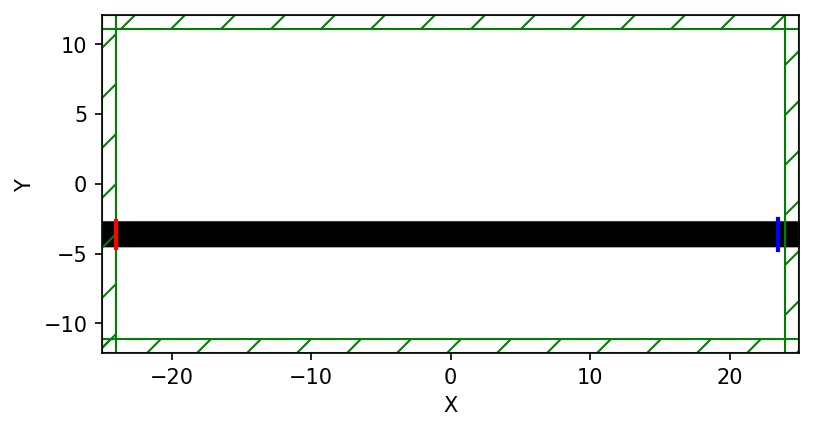

on time step 1168 (time=36.5), 0.00342708 s/step
field decay(t = 50.03125): 3.408601565138778e-18 / 3.408601565138778e-18 = 1.0
on time step 2532 (time=79.125), 0.00293355 s/step
field decay(t = 100.0625): 1.0654659382443618e-08 / 1.0654659382443618e-08 = 1.0
on time step 3861 (time=120.656), 0.00301134 s/step
field decay(t = 150.09375): 5.018279852547521e-06 / 5.018279852547521e-06 = 1.0
on time step 5243 (time=163.844), 0.00289518 s/step
field decay(t = 200.125): 0.08086739682229485 / 0.08086739682229485 = 1.0
on time step 6619 (time=206.844), 0.00290871 s/step
field decay(t = 250.15625): 2.1571711215944984 / 2.1571711215944984 = 1.0
on time step 8028 (time=250.875), 0.00283921 s/step
on time step 9410 (time=294.062), 0.00289618 s/step
field decay(t = 300.1875): 0.9773077359807145 / 2.1571711215944984 = 0.45305063015043795
on time step 10709 (time=334.656), 0.0030809 s/step
field decay(t = 350.21875): 0.011453006227583716 / 2.1571711215944984 = 0.005309271069380018
run 0 finished at 

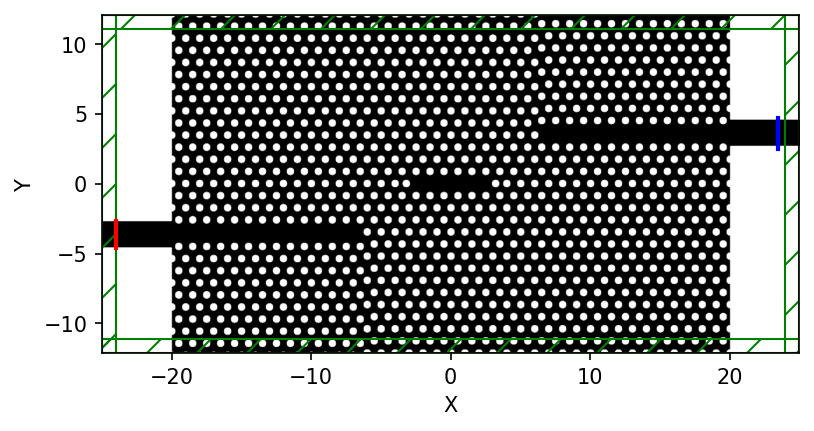

on time step 1057 (time=33.0312), 0.00378551 s/step
on time step 2020 (time=63.125), 0.00415591 s/step
field decay(t = 100.0625): 1.3888193758351807e-18 / 1.3888193758351807e-18 = 1.0
on time step 3210 (time=100.312), 0.00336199 s/step
on time step 4397 (time=137.406), 0.00337148 s/step
field decay(t = 150.09375): 4.3760096407300577e-11 / 4.3760096407300577e-11 = 1.0
on time step 5570 (time=174.062), 0.00341141 s/step
field decay(t = 200.125): 4.362197682874366e-05 / 4.362197682874366e-05 = 1.0
on time step 6724 (time=210.125), 0.00346903 s/step
on time step 7915 (time=247.344), 0.00335892 s/step
field decay(t = 250.15625): 0.0025567101786794894 / 0.0025567101786794894 = 1.0
on time step 9111 (time=284.719), 0.00334716 s/step
field decay(t = 300.1875): 0.002161582830618823 / 0.0025567101786794894 = 0.8454547756896149
on time step 10306 (time=322.062), 0.00334913 s/step
field decay(t = 350.21875): 0.003031815637592172 / 0.003031815637592172 = 1.0
on time step 11502 (time=359.438), 0.003

In [33]:
freqs_wo, psd_out_wo = phc_trans(PhC = False)
freqs_w,  psd_out_w  = phc_trans(PhC = True)

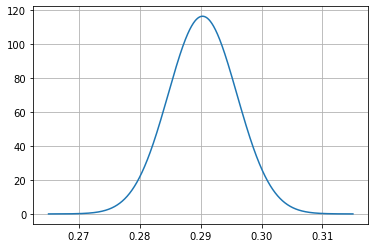

In [34]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

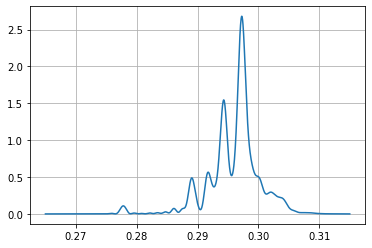

In [35]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

In [36]:
print(freqs_w[186],psd_out_w[186])

0.27120413609072713 0.0001547078965530182


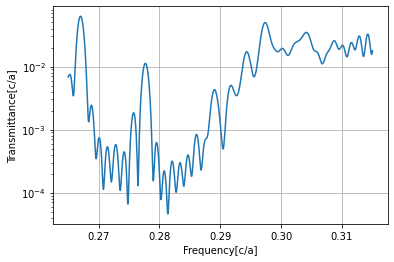

In [37]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

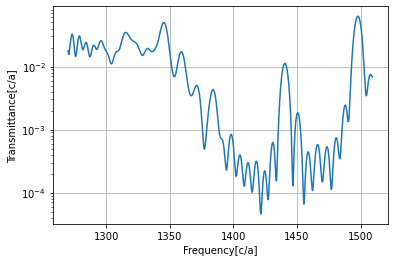

In [42]:
a = 400
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

In [39]:
len(freqs)

1500

## Resonant mode

In [271]:
def phc_resonant(PhC = True):
    # size of PhC (width は √3倍される)
    lengthPhC = 40
    widthPhC = 14
    
    ConnectionWaveguide = 5
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC

    a=1
    nx=widthPhC
    ny=int(lengthPhC)
    x_offset = 0
    y_offset = 0
    cavity = 5
    barrier = 3
    wgi = 1.1
    hole_shift = 0.2

    r = 1/4
    eps = 2.6**2

    # parameter
    waveguide_pos = -a*(barrier + 1 + (wgi-1)*2 )*np.sqrt(3)/2
    
    
    # geometry
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    if PhC == False:
        waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(0, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide]

    if PhC == True:
        waveguide_in = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(-(lengthPhC + ConnectionWaveguide)/2, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide_in]
        
        waveguide_out = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3( (lengthPhC + ConnectionWaveguide)/2, -waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry.append(waveguide_out)

        # Si substrate
        blk = mp.Block(mp.Vector3(lengthPhC, widthPhC*np.sqrt(3), mp.inf),
                             center=mp.Vector3(),
                             material=mp.Medium(epsilon=eps))

        geometry.append(blk)

        # airhole
        location_airhole = unit_1(a, nx, ny, x_offset, y_offset, cavity, barrier, wgi, hole_shift)
        for i in range(len(location_airhole)):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(location_airhole[i][0], location_airhole[i][1])))

    fcen = 0.3   # pulse center frequency
    df = 0.1       # pulse frequency width

    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Hz, mp.Vector3(0))]
    

    pml_layers = [mp.PML(1.0)]
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    
    resolution = 16
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    h = mp.Harminv(mp.Hz, mp.Vector3(), fcen, df)
    sim.run(mp.after_sources(h),
            until_after_sources=300)

    f = plt.figure(dpi=150)
    animate = mp.Animate2D(sim,f=f,fields=mp.Hz,realtime=False,normalize=True)

    sim.run(mp.at_every(1/fcen/20, animate), until=1/fcen)
    plt.show()
    
    
    f = [m.freq for m in h.modes]
    Q = [m.Q for m in h.modes]

    for fiter, qiter in zip(f, Q):
        print(f'Resonant frequency: {fiter}, Q: {qiter}')

-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 2D dimensions.
Computational cell is 50 x 24.25 x 0 with resolution 16
     block, center = (-22.5,-3.63731,0)
          size (6,1.90526,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (22.5,3.63731,0)
          size (6,1.90526,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (0,0,0)
          size (40,24.2487,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     cylinder, center = (-20,-12.2976,0)
          radius 0.25, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-19,-12.2976,0)
          radius 0.25, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     c

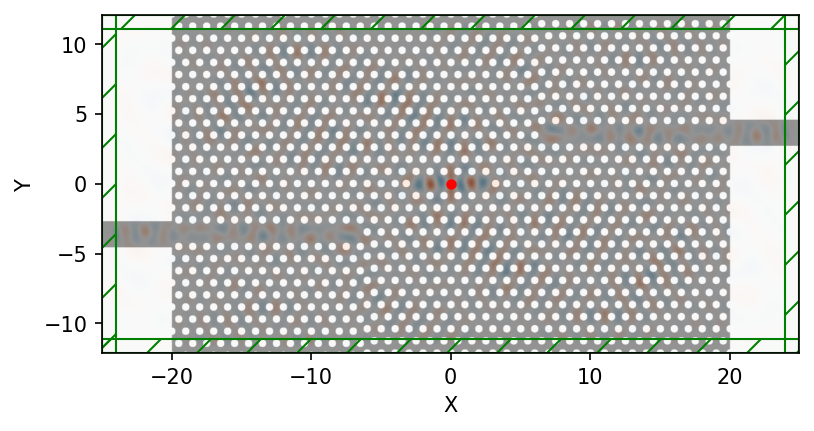

Resonant frequency: 0.2563884396364904, Q: -238.77264189654596
Resonant frequency: 0.26309474476853256, Q: 218.0672695055865
Resonant frequency: 0.27686573099554607, Q: 978.5354111944307
Resonant frequency: 0.3107280268686577, Q: 393.16598169153394
Resonant frequency: 0.33501788072210825, Q: -110.7906562903164


In [272]:
phc_resonant(PhC = True)

## Animation

In [273]:
def phc_anime(PhC = True):
    freq=0.27686573099554607
    # size of PhC (width は √3倍される)
    lengthPhC = 40
    widthPhC = 14
    
    ConnectionWaveguide = 5
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC

    a=1
    nx=widthPhC
    ny=int(lengthPhC)
    x_offset = 0
    y_offset = 0
    cavity = 5
    barrier = 3
    wgi = 1.1
    hole_shift = 0.2

    r = 1/4
    eps = 2.6**2

    # parameter
    waveguide_pos = -a*(barrier + 1 + (wgi-1)*2 )*np.sqrt(3)/2
    
    
    # geometry
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    if PhC == False:
        waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(0, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide]

    if PhC == True:
        waveguide_in = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3(-(lengthPhC + ConnectionWaveguide)/2, waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry = [waveguide_in]
        
        waveguide_out = mp.Block(mp.Vector3(ConnectionWaveguide*1.2,wgi*np.sqrt(3),mp.inf),
                             center=mp.Vector3( (lengthPhC + ConnectionWaveguide)/2, -waveguide_pos),
                             material=mp.Medium(epsilon=eps))
        geometry.append(waveguide_out)

        # Si substrate
        blk = mp.Block(mp.Vector3(lengthPhC, widthPhC*np.sqrt(3), mp.inf),
                             center=mp.Vector3(),
                             material=mp.Medium(epsilon=eps))

        geometry.append(blk)

        # airhole
        location_airhole = unit_1(a, nx, ny, x_offset, y_offset, cavity, barrier, wgi, hole_shift)
        for i in range(len(location_airhole)):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(location_airhole[i][0], location_airhole[i][1])))

    fcen = 0.3   # pulse center frequency
    df = 0.1       # pulse frequency width

    sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                     component=mp.Hz,
                     center=mp.Vector3(-length/2 +1,waveguide_pos))]

     
    pml_layers = [mp.PML(1.0)]
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    
    resolution = 8
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    return sim

In [274]:
T=4
sim = phc_anime(PhC = True)
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(sim, fields=mp.Hz, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(T,Animate),until=T*600)
plt.close()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000143051 s
Working in 2D dimensions.
Computational cell is 50 x 24.25 x 0 with resolution 8
     block, center = (-22.5,-3.63731,0)
          size (6,1.90526,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (22.5,3.63731,0)
          size (6,1.90526,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (0,0,0)
          size (40,24.2487,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     cylinder, center = (-20,-12.2976,0)
          radius 0.25, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-19,-12.2976,0)
          radius 0.25, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cy

In [275]:
#Animate.to_gif(10,"test.gif")

filename = "L3_L5.mp4"
Animate.to_mp4(10,filename)
from IPython.display import Video
Video(filename)

Generating MP4...
